## Autoencoders

In [1]:
cd ../../src

/home/kuba/Projects/notebooks/examples-counterexamples/src


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import theano
import theano.tensor as T

from fetch_mnist import preprocessed_mnist
from neural_nets.autoencoder import Autoencoder 

In [3]:
X_train, X_test, y_train, y_test = preprocessed_mnist(random_state=0, preprocess='min_max_scale', scale_min=-1, scale_max=1)

/opt/anaconda3/envs/nnets/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [4]:
def train_autoencoder(**kwargs):
  autoencoder = Autoencoder(**kwargs)

  %time autoencoder.fit(X_train)

  plt.plot(autoencoder.losses)
  plt.show()
  return autoencoder

def plot_two_img_rows(X1, X2, title, j=5):
  f, axes = plt.subplots(2, j, figsize=(20, 40 / j))
  f.suptitle(title)
  for k, x in zip(range(2), [X1, X2]):
    for i in range(j):
      ax = axes[k, i]
      img = x[i, :].reshape(28, 28)
      ax.imshow(img, cmap='gray')
      ax.axis('off')
  plt.show()

def present_autoencoder_reconstruction(autoencoder):
 
  X_test_retrieved = autoencoder.retrieve(X_test)
  X_train_retrieved = autoencoder.retrieve(X_train)
  plot_two_img_rows(X_train, X_train_retrieved, 'train', 10)
  plot_two_img_rows(X_test, X_test_retrieved, 'test', 10)
 

In [11]:
shared_args = (dict(
  initialization_type='xavier',
  optimization_params={
    'method': 'nesterov',
    'decay': 0.9},
  activation=T.tanh,
  n_iter=1000,
  hidden_sizes = [100],
  batch_size = 1000,
  learning_rate=0.001))

CPU times: user 2min 23s, sys: 4.16 s, total: 2min 27s
Wall time: 1min 14s


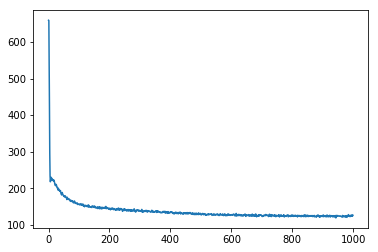

CPU times: user 2min 24s, sys: 4.16 s, total: 2min 28s
Wall time: 1min 14s


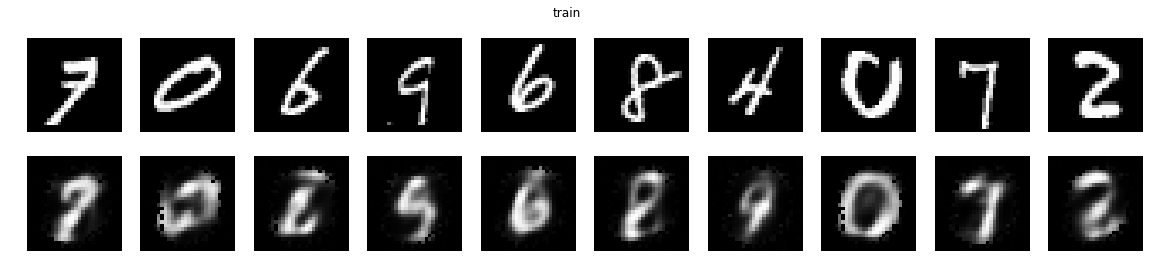

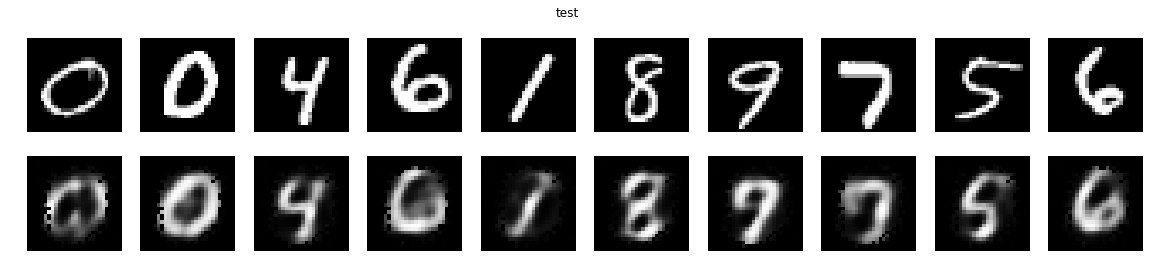

In [12]:
args_dict = (dict(
  lmbda=1e-4,
  l1_ratio=0.5))

args_dict.update(shared_args)

%time autoencoder = train_autoencoder(**args_dict)

present_autoencoder_reconstruction(autoencoder)

## Contractive encoders

Contractive encoders use regularization that is based on hidden layer's Jacobian.

Objective function for CAe becomes

$$L_{cae}(x; W) =  L_{ae}(x; W) + \| J(H(x; W)) \|_F^2$$

In case of standard NN's (the ones with pointwise activation $S$) 

$$\| J(H(x; W)) \|_F^2 = \sum_{i} (S'(xW_{. i} + b_i))^2 \sum_{j} W_{ij}^2$$

CPU times: user 2min 14s, sys: 4.34 s, total: 2min 18s
Wall time: 1min 9s


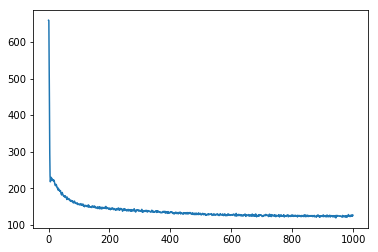

CPU times: user 2min 14s, sys: 4.34 s, total: 2min 19s
Wall time: 1min 9s


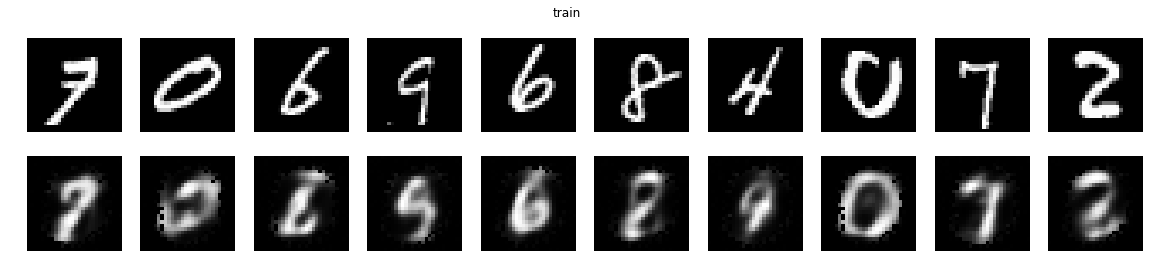

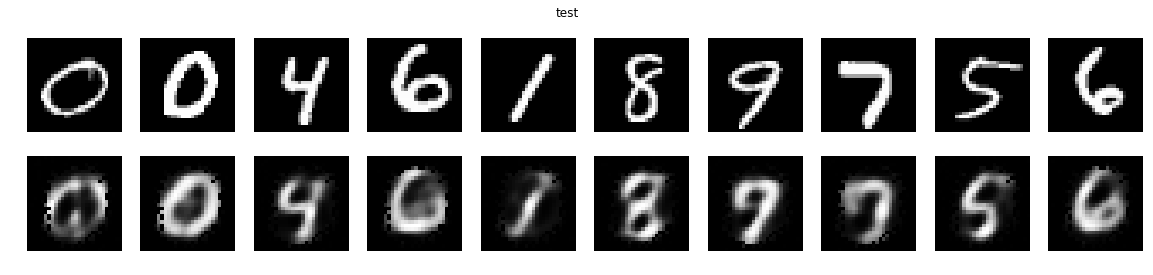

In [14]:
args_dict = (dict(
  autoencoder_type='contractive',
  lmbda=1e-6,
  l1_ratio=0.5))

args_dict.update(shared_args)

%time autoencoder = train_autoencoder(**args_dict)

present_autoencoder_reconstruction(autoencoder)

In [15]:
def class_mean_and_cov(i):
  idxs = np.where(y_train == i)[0]
  X_cl = X_train[idxs, :]
  X_cl_mean = X_cl.mean(axis=0)
  train_cov = (X_cl.T - X_cl_mean[:, np.newaxis]) @ (X_cl - X_cl_mean)
  return train_cov, X_cl_mean

def generate_samples_from_class(i):
  raw_noise = np.random.uniform(low=-1, size=(10, 28* 28))
  cov, mean = class_mean_and_cov(i)
  noise = (raw_noise + mean) @ cov 
  return autoencoder.retrieve(noise)

## Reconstructing digits

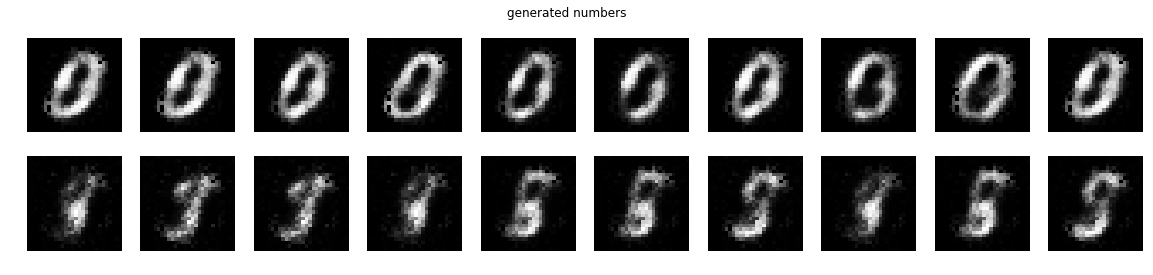

In [16]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

generated_zeros = generate_samples_from_class(0)
generated_eights = generate_samples_from_class(8)

plot_two_img_rows(generated_zeros, generated_eights, 'generated numbers', j=10)